In [ ]:
# Below a rough architecture of how we're going to tie things together.

# Embedding
token_ids = tokenizer(raw_text)
input_data = embedding(token_ids)

# Decoder Blocks (n)
## MHSelfAttn
residual = input_data.copy()
x = layernorm(input_data)  # pre-layer normalization
x = mhselfattn(x)
x = x + residual
# Feed Forward
residual = x.copy()
x = layernorm(x)     --> goes in self.ff in the Block class
x = linear(x)        --> goes in self.ff in the Block class
x = activation(x)    --> goes in self.ff in the Block class
x = linear_2(x)      --> goes in self.ff in the Block class
x = dropout(x)       --> goes in self.ff in the Block class# Vid puts dropout before linear_2 - why? 
x = x + residual

# Normalization after all the decoder blocks
x = layernorm(x) # Need to do this because we're doing pre-layer normalization

# Projection (this includes a linear projection layer of which the output is softmaxed)
token_ids = embedding_reverse(x)

#  During training
loss = cross_entropy(tokend_ids, labels)

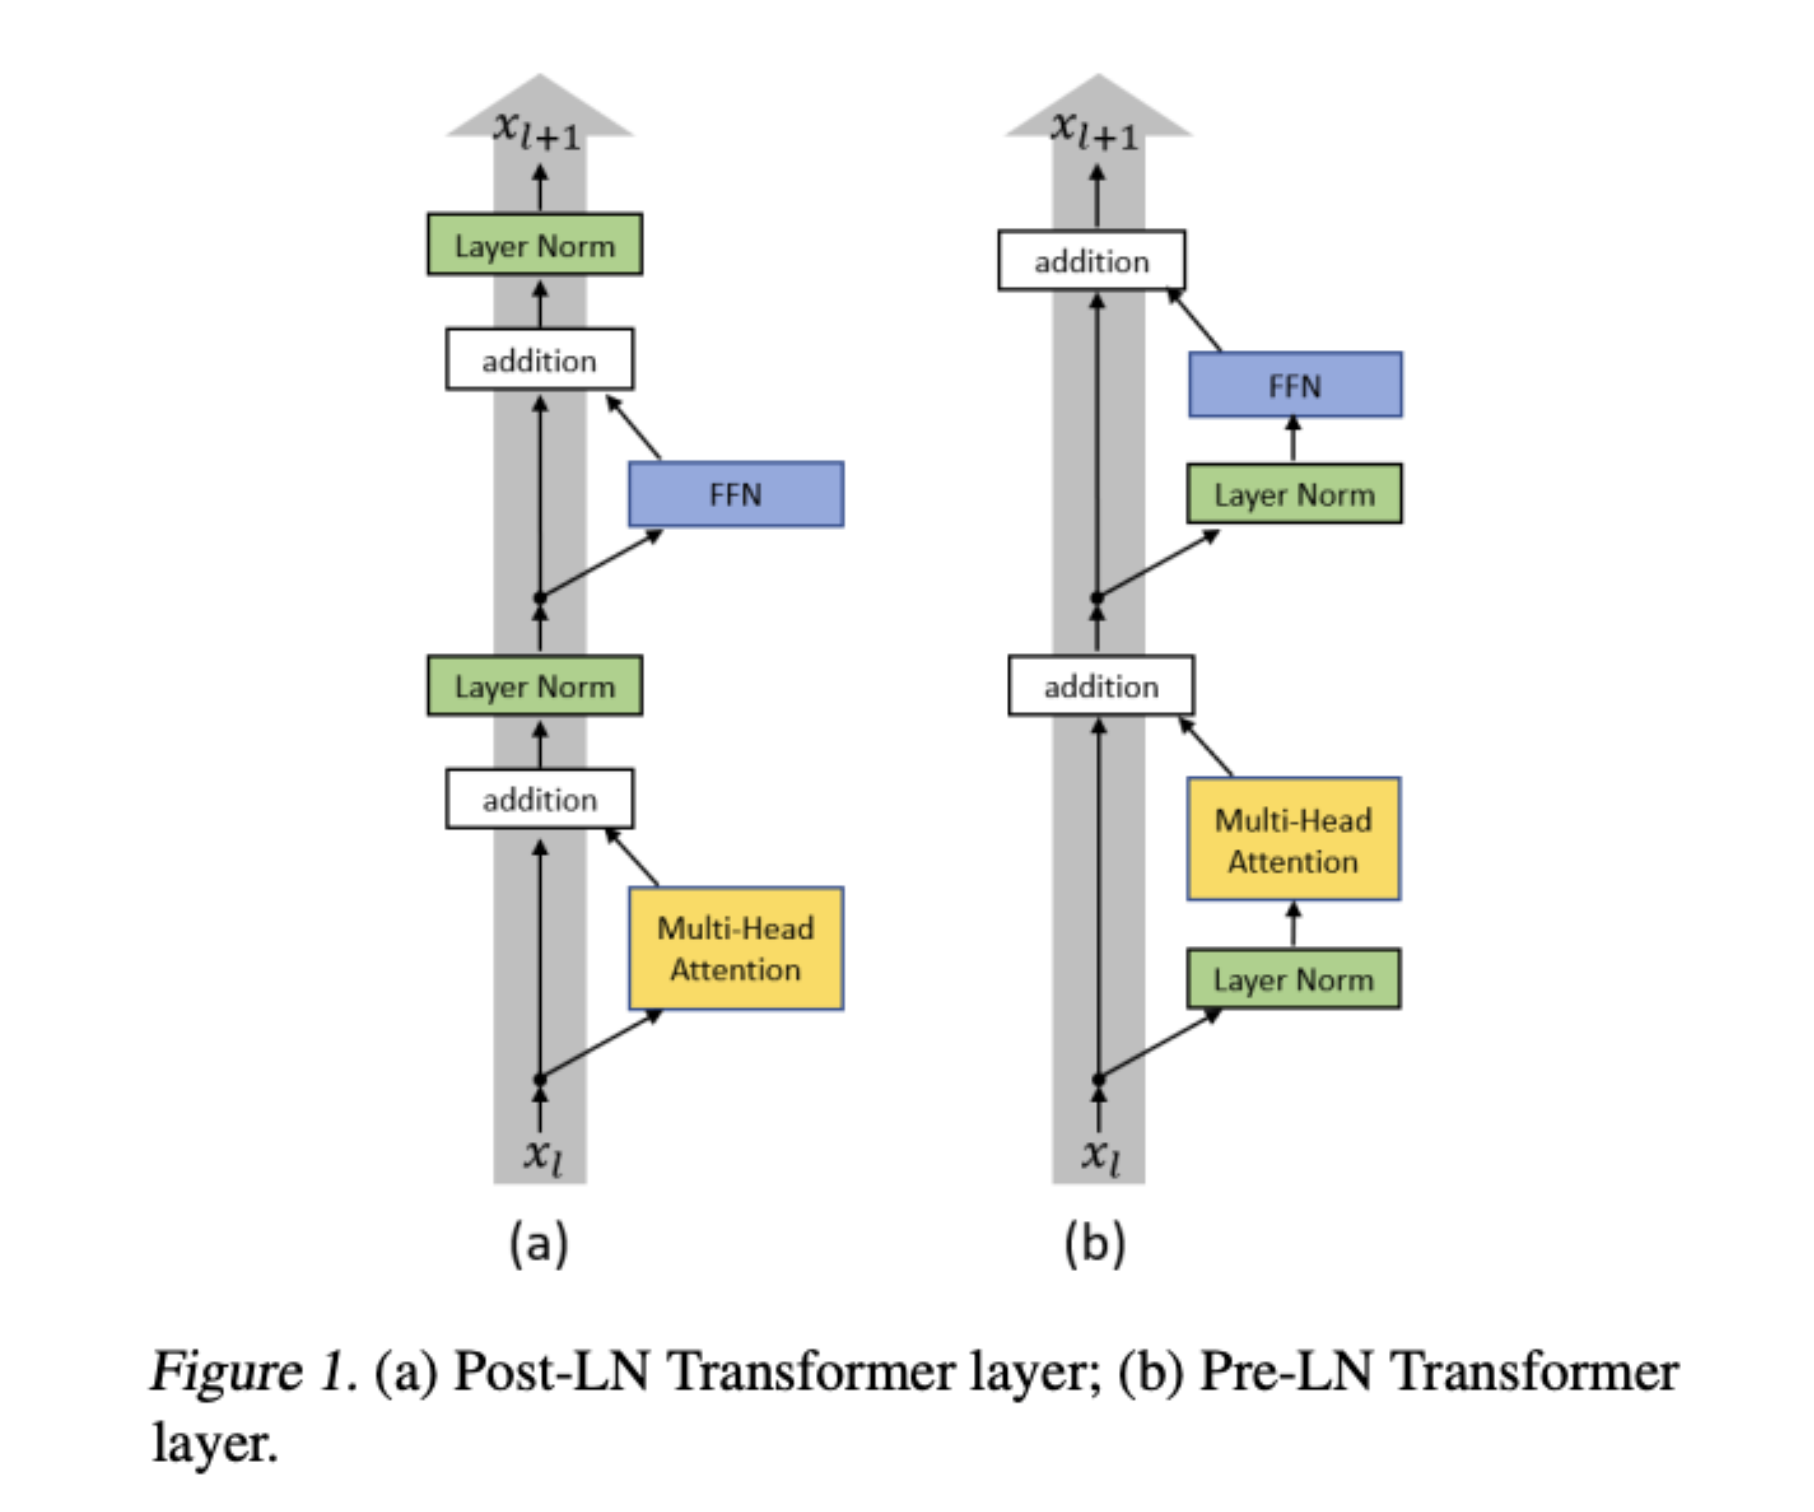

In [1]:
from IPython.display import Image
Image("./pre_vs_post_layer_norm.png")

In [3]:
# Overall changes we made:
# 1. We standardize on relalive_position (so without final s)


import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt

######################
# New New New - this code did not previously appear in any of the stages, it's new to the stage
######################

# We create a class for the block

class Block(nn.Module):
    def __init__(self, memory=None, dropout=0.):
        if memory:
            self.mhselfattn = MHSelfAttnWithMem(self.embed_dim, memory, num_attn_heads=self.num_attn_heads, head_dim=self.head_dim, dropout=self.dropout)
        else:
            self.mhselfattn = MHSelfAttnWithMem(self.embed_dim, num_attn_heads=self.num_attn_heads, head_dim=self.head_dim, dropout=self.dropout)


        # nn.Sequential vs. nn.ModuleList -> the Sequential you can call and it will automatically pass through all layers
        # vs. the ModuleList where you still have to call "for component in MList, x = component(x)" 
        # ModuleList is really just a list
        self.ff = nn.Sequential(
            nn.LayerNorm(dim), # This is the second pre-layer norm (highest one)
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim))
            

    def forward(self, input_data, recurrence, relative_position):
        residual = input_data

        # This is the first pre-layer norm (bottom one)
        norm = nn.LayerNorm(dim)    # Strange that we're creating this in the forward() -> pull this into the constructor
        input_data = norm(input_data)
        attn_out, new_recurrence = self.mhselfattn(input_data, relative_position=relative_position, recurrence=recurrence)
        attn_out += residual

        residual = attn_out
        ff_out = self.ff(attn_out)
        ff_out += residual

        # Since we're doing pre-layer norm. we'll have to do one more LayerNorm after the last stacked Block
        # ff_out is standard, new_recurrence is special here, we save these and pass these in when we call this Block the next time
        return ff_out, new_recurrence  
        
# Now we need a class that stacks multiple of these blocks, and does a final normalization and then a projection

class TransformerXLWithMemory(nn.Module):
    def __init__(
        self,
        embed_dim,
        vocab_size, # For the projection
        num_attn_heads = 8,
        depth = 10,
        dropout=0,
        head_dim = 64,
        max_mems = 32000,
        top_k = 5,
    );
        super().__init__()
        self.num_attn_heads = num_attn_heads
        self.embed_dim = embed_dim
        self.dropout = dropout
        self.depth = depth
        self.head_dim = head_dim
        self.max_mems = max_mems
        self.top_k = top_k

        # Now we create the things of which we only need one, for our whole model:
        # One relative positioning
        # One embedding for the token ids
        # One memory

        self.relative_position = RelativePosition(scaling_factor=head_dim**0.5, num_attn_heads=self.num_attn_heads)

        # Why does knn need its own relative position? Look into this TO DO.
        self.relative_position_knn = RelativePosition(scaling_factor=head_dim**0.5, num_attn_heads=self.num_attn_heads)
        self.embedding = nn.Embedding(vocab_size,self.embed_dim)
        self.memory = Memory(head_dim*num_attn_heads, self.max_mems)

        # Now we stack the whole model up with ModuleList

        self.layers = nn.ModuleList([]) # You must call the layers (modules) individually but that is what we want

        for i in range(self.depth):

            if i == self.depth - 2: # The paper makes it so that the SECOND TO LAST layer is the layer with memory, so: -2
                memory = self.memory
            else:
                memory = None

            self.layers.append(Block(memory)) # Block creates a block with memory if the incoming memory parameter is not None

        # Because we do pre-layer normalization we need to do one final normalization, and then we can do the projection
        self.to_logits = nn.Sequential(
            nn.LayerNorm(self.embed_dim),
            nn.Linear(self.embed_dim, vocab_size)
        )

    def forward(self, 
                input_data,        # At this point these are still the tokenids
                relative_position=None, # Each block needs these coming in, in its forward()
                recurrence=None,         # Each block needs these coming in, in its forward()
                labels=None):

        b_s, seq_len = input_data.shape[0], input_data.shape[1]

        # Get the rel pos matrices
        relative_position = self.relative_position(seq_len)
        relative_position_knn = self.relative_position_knn(seq_len)

        # You need to start again from this point on and understand.
        # First up: try out what the zip does in the training loop ... do we really go from left to right anf then up as in the slide, or
        # Do we go up first, taking the first column, and then go to the second column etc. TRY THIS OUT

        if recurrence is not None:            # This should only be the case for the very first chunk
            recurrence = recurrence           # 2nd chunk and onward ** for a document ** -> how is it channeled to that same document?
        else:
            recurrence = (None,) * self.depth # We only reach this branch for the very first chunk of a document
        
        memory_iterator = iter(recurrence)    # Each layer needs to get its own recurrence 

        new_memory = []                       # We're going to store the new recurrences in here (for every layer)

        # Create embeddings for the input token ids

        input_data = self.embedding(input_data)
        
        # Now we call each module in our ModuleList. We HAVE to do this since we're using ModuleList. We WANT to do this because we're 
        # passing in some custom stuff.

        find idx, block in enumerate(self.layers): # (Attention) block and layer are the same thing

            if idx == self.depth - 2:              # The knn-enhanced layer
                relative_position = relative_position_knn
            else:
                relative_position = relative_position

            input_data, new_recurrence = block(input_data, next(memory_iterator), relative_position) # We overwrite input_data

            if new_recurrence is not None:
                new_memory.append[new_recurrence]
      
        # Get the logits

        logits = self.to_logits(input_data)    # Here input_data contains the output of the last block

        # Calculate the loss

        loss = F.cross_entropy(rearrange(logits, 'b n c -> b c n'), labels)
        # 28:49 understand what the rearrange does
        # torch.nn.functional.cross_entropy:
        # input (Tensor) – Predicted unnormalized logits; see Shape section below for supported shapes.
        # target (Tensor) – Ground truth class indices or class probabilities; see Shape section below for supported shapes.
        # Explanation for rearrange:
        # Example 2: Sequence Classification (e.g., Token Classification)
        # For a batch of sequences where each token is classified into one of 50,000 classes, with a batch size of 16 and sequence length 50:
        # Input shape: (16,50000,50)
        # Target shape: (16,50), where each element in the sequence has an integer representing the class.


######################
# End New New New 
######################

# Adding the RelativePosition class here from ExplainPosEncoding - changes are marked with comments

class RelativePosition(nn.Module):

    # Adding default values for num_buckets, max_distance and num_attn_heads
    def __init__(self, scaling_factor, num_buckets=32, max_distance=128, num_attn_heads=8):
        
        super().__init__()
        self.scaling_factor = scaling_factor
        self.num_buckets = num_buckets
        self.max_distance = max_distance
        self.rel_pos_embeddings = nn.Embedding(num_buckets, num_attn_heads)

    def forward(self, seq_len, max_context_len=None): # Added the None default value, see below.

        # In Ep. 7 the vid doesn't use max_context_len but simply uses 2 * seq_len
        if max_context_men is None:
            max_context_len = 2 * seq_len
        
        q_pos = torch.arange(seq_len, dtype=torch.long)               
        #k_pos = torch.arange(max_context_len, dtype=torch.long) 
        # We don't want the below:
        #[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        #[-1,  0,  1,  2,  3,  4,  5,  6,  7,  8],
        #[-2, -1,  0,  1,  2,  3,  4,  5,  6,  7],
        #[-3, -2, -1,  0,  1,  2,  3,  4,  5,  6],
        #[-4, -3, -2, -1,  0,  1,  2,  3,  4,  5]
        # But rather this, since the block on the left is the "past" i.e., we want 0 to align with the position of the current last known token:
        #[-5, -4, -3, -2, -1,  0,  1,  2,  3,  4],
        #[-6, -5, -4, -3, -2, -1,  0,  1,  2,  3],
        #[-7, -6, -5, -4, -3, -2, -1,  0,  1,  2],
        #[-8, -7, -6, -5, -4, -3, -2, -1,  0,  1],
        #[-9, -8, -7, -6, -5, -4, -3, -2, -1,  0]]
        # This is obtained with this change:
        k_pos = torch.arange(-max_context_len/2,max_context_len/2 , dtype=torch.long)               
        q_pos = q_pos.reshape(q_pos.shape[0], 1) # We make q a column vector, this is not change, just clarification
        rel_pos = k_pos - q_pos
        rel_pos = -rel_pos
        rel_pos = torch.max(rel_pos, torch.zeros_like(rel_pos))
        
        num_token_buckets = self.num_buckets // 2
        is_exact = rel_pos < num_token_buckets

        val_if_large = \
        num_token_buckets + \
        (torch.log(rel_pos.float() / num_token_buckets) / math.log(self.max_distance / num_token_buckets) * (self.num_buckets - num_token_buckets))
        val_if_large = val_if_large.long()
        val_if_large = torch.min(val_if_large, torch.full_like(val_if_large, num_buckets - 1))

        position_bucket_indices = torch.where(is_exact, rel_pos, val_if_large)

        q_k_rel_pos_embeddings = self.rel_pos_embeddings(position_bucket_indices)
        q_k_rel_pos_embeddings = q_k_rel_pos_embeddings.transpose(-1,-2).transpose(0,1)
        q_k_rel_pos_embeddings = q_k_rel_pos_embeddings.unsqueeze(0)

        return q_k_rel_pos_embeddings * self.scaling_factor   

# Adding the Memory class here from ExplainMemory without changes

class Memory:

    def __init__(self, mem_dim=64, max_mems=10000):

        self.index = faiss.IndexFlatL2(mem_dim)
        db_filepath = "./numpy.memmap"          
        self.db = np.memmap(db_filepath, mode='w+', dtype=np.float32, shape = (max_mems,2,mem_dim))
        self.db_offset = 0

    def add(self, keys_and_values): 

        keys_and_values = keys_and_values.reshape(-1, 2, mem_dim) 
        keys = keys_and_values[:,0,:]
        keys = keys.numpy()

        self.index.add(keys)
        
        num_added = keys_and_values.shape[0]
        indexes_added = (np.arange(num_added) + self.db_offset)
        self.db[indexes_added] = keys_and_values 
        self.db_offset = self.db_offset + num_added
        self.db.flush() 

    def query(self, queries, top_k=2):  

        b_s = queries.shape[0]
        seq_len = queries.shape[1]

        queries = queries.reshape(-1, mem_dim) 
        queries = queries.numpy()
        
        distances, ids = self.index.search(queries, top_k)
        
        mem_keys_and_values = self.db[ids]
        mem_keys_and_values = mem_keys_and_values.reshape(b_s, seq_len, top_k, 2, mem_dim)
        mem_keys_and_values = torch.from_numpy(mem_keys_and_values)
        
        return mem_keys_and_values
    
    def clear():

        self.index.reset()
        self.db[:] = 0       
        self.db_offset = 0

# Copied from ExplainRecurrence - changes have comments, were first made in MHSelfAttnWithMem

class MHSelfAttn(nn.Module):

    #def __init__(self, embed_dim, num_attn_heads=8, head_dim=32):
    # Just like for MHSelfAttnWithMem we pass in memory and dropout
    def __init__(self, embed_dim, memory, num_attn_heads=8, head_dim=32, top_k=3, dropout=0.): 
        super().__init__()
        self.num_attn_heads = num_attn_heads        
        self.Wq = nn.Linear(embed_dim, num_attn_heads * head_dim, bias=False)
        self.Wk = nn.Linear(embed_dim, num_attn_heads * head_dim, bias=False)
        self.Wv = nn.Linear(embed_dim, num_attn_heads * head_dim, bias=False)
        self.Wo = nn.Linear(num_attn_heads * head_dim, embed_dim)

        # Same as in MHSelfAttnWithMem
        self.memory = memory
        self.dropout = nn.Dropout(dropout)

    #def forward(self, input_data, recurrence=None):
    # Same changes as in MHSelfAttnWithMem
    def forward(self, input_data, relative_position=None, recurrence=None):
        b_s, seq_len = input_data.shape[:2]
        
        queries = self.Wq(input_data)
        keys = self.Wk(input_data)
        values = self.Wv(input_data)

        # Same as in MHSelfAttnWithMem
        queries = F.normalize(queries, dim=-1)
        keys = F.normalize(keys, dim=-1)  

        if recurrence is not None:
            # Copied from above:
            recurrence_keys, recurrence_values = recurrence.unbind(dim=-2)
            keys = torch.cat((recurrence_keys, keys), dim=-2)                 
            values = torch.cat((recurrence_values, values), dim=-2)           
            recurrence_length = recurrence_keys.shape[1]       
        
        queries = rearrange(queries, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)
        keys = rearrange(keys, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)
        values = rearrange(values, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)

        attn_scores = einsum(queries, keys, 'b h s1 d, b h s2 d -> b h s1 s2')

        i, j = attn_scores.shape[-2:]

        # Same as in MHSelfAttnWithMem
        if relative_position is not None:
            attn_scores = relative_position[..., -i:, -j:] + attn_scores
        
        mask = torch.ones((i,j), dtype=torch.bool).triu(diagonal=(j-i+1))
        masked_attn_scores = attn_scores.masked_fill(mask, float("-inf"))

        attn_weights = F.softmax(masked_attn_scores, dim = -1)

        # Same as in MHSelfAttnWithMem
        attn_weights = self.dropout(att_weights)

        head_context_vectors = attn_weights@values
        
        multihead_context_vector = rearrange(head_context_vectors, 'b h s d -> b s (h d)')
        out = self.Wo(multihead_context_vector)

        keys = rearrange(keys, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)
        values = rearrange(values, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)
        k_v_stacked = torch.stack((keys, values), dim=-2) # (b_s, seq_len, 2, embed_dim)

        if recurrence is not None:
            recurrence, current = k_v_stacked[:, :-recurrence_length], k_v_stacked[:, -recurrence_length:]
        else: 
            current = k_v_stacked
            
        return out, current

# Copied from ExplainRecurrence - changes are marked with comments

class MHSelfAttnWithMem(nn.Module):

#    def __init__(self, embed_dim, num_attn_heads=8, head_dim=32, top_k=3): 
    # We are going to add the mem in the init() vs. in fwd().
    # We are also adding dropout.
    def __init__(self, embed_dim, memory, num_attn_heads=8, head_dim=32, top_k=3, dropout=0.): 
        super().__init__()
        self.num_attn_heads = num_attn_heads
        self.top_k = top_k
        self.Wq = nn.Linear(embed_dim, num_attn_heads * head_dim, bias=False)
        self.Wk = nn.Linear(embed_dim, num_attn_heads * head_dim, bias=False)
        self.Wv = nn.Linear(embed_dim, num_attn_heads * head_dim, bias=False)
        self.Wo = nn.Linear(num_attn_heads * head_dim, embed_dim) 

        self.gate = nn.Parameter(torch.randn(num_attn_heads, 1, 1))

        # New:
        self.memory = memory
        self.dropout = nn.Dropout(dropout)

    #def forward(self, input_data, memory, recurrence):
    # Remover memory here as we're initializing with it, but add relative positions.
    def forward(self, input_data, relative_position=None, recurrence=None):  # Added =None here for recurrence as well
        b_s, seq_len = input_data.shape[:2]
        
        queries = self.Wq(input_data)
        keys = self.Wk(input_data)
        values = self.Wv(input_data)

        # We add normalization here - this is not the standard pre-layer normalization, but rather a normalization to make sure that
        # memory that gets stored is normalized. If we don't do this, then mems that should match could sometimes not match, because
        # there would be model "drift" meaning that the model would generate the mems in a different "range".
        # This is also why we don't normalize the values here, it's really about being able to find matching keys for quearies in the mem.
        queries = F.normalize(queries, dim=-1)
        keys = F.normalize(keys, dim=-1)       

        if recurrence is not None:
            recurrence_keys, recurrence_values = recurrence.unbind(dim=-2)
            keys = torch.cat((recurrence_keys, keys), dim=-2)                
            values = torch.cat((recurrence_values, values), dim=-2)
            recurrence_length = recurrence_keys.shape[1]
        
        queries = rearrange(queries, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)
        keys = rearrange(keys, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)
        values = rearrange(values, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)

        attn_scores = einsum(queries, keys, 'b h s1 d, b h s2 d -> b h s1 s2')

        i, j = attn_scores.shape[-2:]

        # Add relative positions. These just get added to the attn_scores
        # Note that i == si, j == s2
        if relative_position is not None:
            # ... means -> as many ":" as needed to come to the last two dimensions
            # attn_scores[:, -i:, -j:] gives the same result as qv[:, :i, :j] -> basically we go over all indices in the final two dims
            attn_scores = relative_position[..., -i:, -j:] + attn_scores
        
        mask = torch.ones((i,j), dtype=torch.bool).triu(diagonal=(j-i+1))
        masked_attn_scores = attn_scores.masked_fill(mask, float("-inf"))

        attn_weights = F.softmax(masked_attn_scores, dim = -1)

        # We add dropout, which must go after softmaxing
        attn_weights = self.dropout(att_weights)
        
        head_context_vectors = attn_weights@values
        
        queries = rearrange(queries, 'b h s d -> b s (h d)')

        mem_keys_and_values = memory.query(queries, self.top_k)

        mem_keys, mem_values = mem_keys_and_values.unbind(-2)
        
        mem_keys = rearrange(mem_keys, 'b s k (h d) -> b h s k d', h = num_attn_heads)
        mem_values = rearrange(mem_values, 'b s k (h d) -> b h s k d', h = num_attn_heads)

        queries = rearrange(queries, 'b s (h d) -> b h s d', h=num_attn_heads)
        
        attn_scores = einsum(queries, mem_keys, 'b h s d, b h s k d -> b h s k')       
        attn_scores = attn_scores * (head_dim ** -0.5)

        attn_weights = F.softmax(attn_scores, dim = -1)
        
        attn_weights = self.dropout(attn_weigths)

        mem_context_vectors = einsum(attn_weights, mem_values, 'b h s k, b h s k d -> b h s d')

        head_mem_context_vectors = (mem_context_vectors * self.gate) + (head_context_vectors * (1 - self.gate))
        
        multihead_context_vector = rearrange(head_mem_context_vector, 'b h s d -> b s (h d)')
        out = self.Wo(multihead_context_vector)

        keys = rearrange(keys, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)
        values = rearrange(values, 'b_s seq_len (num_attn_heads head_dim) -> b_s num_attn_heads seq_len head_dim', num_attn_heads=self.num_attn_heads)
        k_v_stacked = torch.stack((keys, values), dim=-2)
        
        if recurrence is not None:
            recurrence, current = k_v_stacked[:, :-recurrence_length], k_v_stacked[:, -recurrence_length:]
        else: 
            current = k_v_stacked

        knn.add(current)

        return out, current


# Copy in the MHSelfAttn - no changes!

class MHSelfAttn(nn.Module):
    def __init__(self, embed_dim, num_attn_heads):
        super().__init__()
        attn_head_input_dim = embed_dim
        attn_head_output_dim = embed_dim // num_attn_heads

        # Just add self..
        self.Wo = nn.Linear(embed_dim, embed_dim)

        # Just add self..
        self.attn_heads = nn.ModuleList(
            [AttnHead(attn_head_input_dim, attn_head_output_dim) for _ in range(num_attn_heads)]
        )


    def forward(self, input_data):

        
        # Refer to attn_heads with self..
        concatenated_head_context_vectors = torch.cat(
               [attn_head(input_data) for attn_head in self.attn_heads], dim=-1
        )
        # Refer to Wo with self..
        multihead_context_vector = self.Wo(concatenated_head_context_vectors)

        # return it
        return multihead_context_vector


# The rest does not change from 3 - this is the AttenHead Class from 3:

class AttnHead(nn.Module):

    def __init__(self, attn_head_input_dim, attn_head_output_dim):
        super().__init__()

        # Just add self..
        self.Wq = nn.Linear(attn_head_input_dim, attn_head_output_dim, bias=False) 
        self.Wk = nn.Linear(attn_head_input_dim, attn_head_output_dim, bias=False)
        self.Wv = nn.Linear(attn_head_input_dim, attn_head_output_dim, bias=False) 

    def forward(self, input_data):

        # Just add self..
        queries = self.Wq(input_data)     
        keys = self.Wk(input_data)
        values = self.Wv(input_data)

        dim_of_key = keys.size(-1) 
        attn_scores = queries @ keys.transpose(-2,-1)/sqrt(dim_of_key) 
        mask = torch.ones((attn_scores.shape[-1], attn_scores.shape[-1]), dtype=torch.bool).triu(diagonal=1)
        attn_scores = attn_scores.masked_fill(mask, float("-inf"))
        attn_weights = F.softmax(attn_scores, dim = -1)
        head_context_vector = attn_weights@values 
        return head_context_vector  

In [7]:
import numpy as np
#import torch
#import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import datasets

# Copy the training loop, comment out the last line.
# Difference: we isolate the data processsing code in a function, so that we also can load and process (!) the validation dataset

# Addd "train_" to name
train_dataset = datasets.load_dataset("ccdv/arxiv-summarization", split="train", streaming=True)
raw_train_dataset = list(train_dataset.take(10))

# Add the same for validation:
valid_dataset = datasets.load_dataset("ccdv/arxiv-summarization", split="validation", streaming=True)
raw_valid_dataset = list(valid_dataset.take(10))


def clip_article(article, chunk_size):
    remainder = len(article) % chunk_size
    return article[:-remainder]

def process_dataset(dataset, segments=10, seg_len=512):
    chunk_size = segments * seg_len


    raw_articles = [x['article'] for x in raw_dataset] 
    raw_articles = [x for x in raw_articles if len(x) > segments * seg_len]     # Replaced "5120" hardcoded with calculation
    unique_tokens = set(''.join([raw_article for raw_article in raw_articles]))
    raw_articles_as_token_ids = [np.fromstring(raw_article, dtype=np.uint8) for raw_article in raw_articles]



    clipped_raw_articles_as_token_ids = [clip_article(raw_article, chunk_size) for raw_article in raw_articles_as_token_ids]
    clipped_raw_arts_as_t_ids_as_chunks = np.array([article.reshape(-1, chunk_size) for article in clipped_raw_articles_as_token_ids], dtype=object)
    # Slight name change (carry it back if you have time): let's call it processed_dataset
    processed_dataset = torch.tensor(np.concatenate(clipped_raw_arts_as_t_ids_as_chunks), dtype=torch.long)

    return processed_dataset

processed_train_dataset = process_dataset(raw_train_dataset)
processed_valid_dataset = process_dataset(raw_valid_dataset)

    
# Comment this out - we're creating the loader below
#loader = iter(DataLoader(processed_data, batch_size=8, shuffle=True))

/var/folders/xw/rbg9dqnx4h534h57wgqgvpkr0000gn/T/ipykernel_43889/2023826921.py:30: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  raw_articles_as_token_ids = [np.fromstring(raw_article, dtype=np.uint8) for raw_article in raw_articles]


The model below follows the transformer decoder architecture.
Notes:
1. We're not doing the skipconnections yet at this point - when you add that you cannot use Sequential anymore.
2. We are doing post layer normalization here, while in our "core" transformer arch we do pre (so there we have one more norm at the end that we need to add.

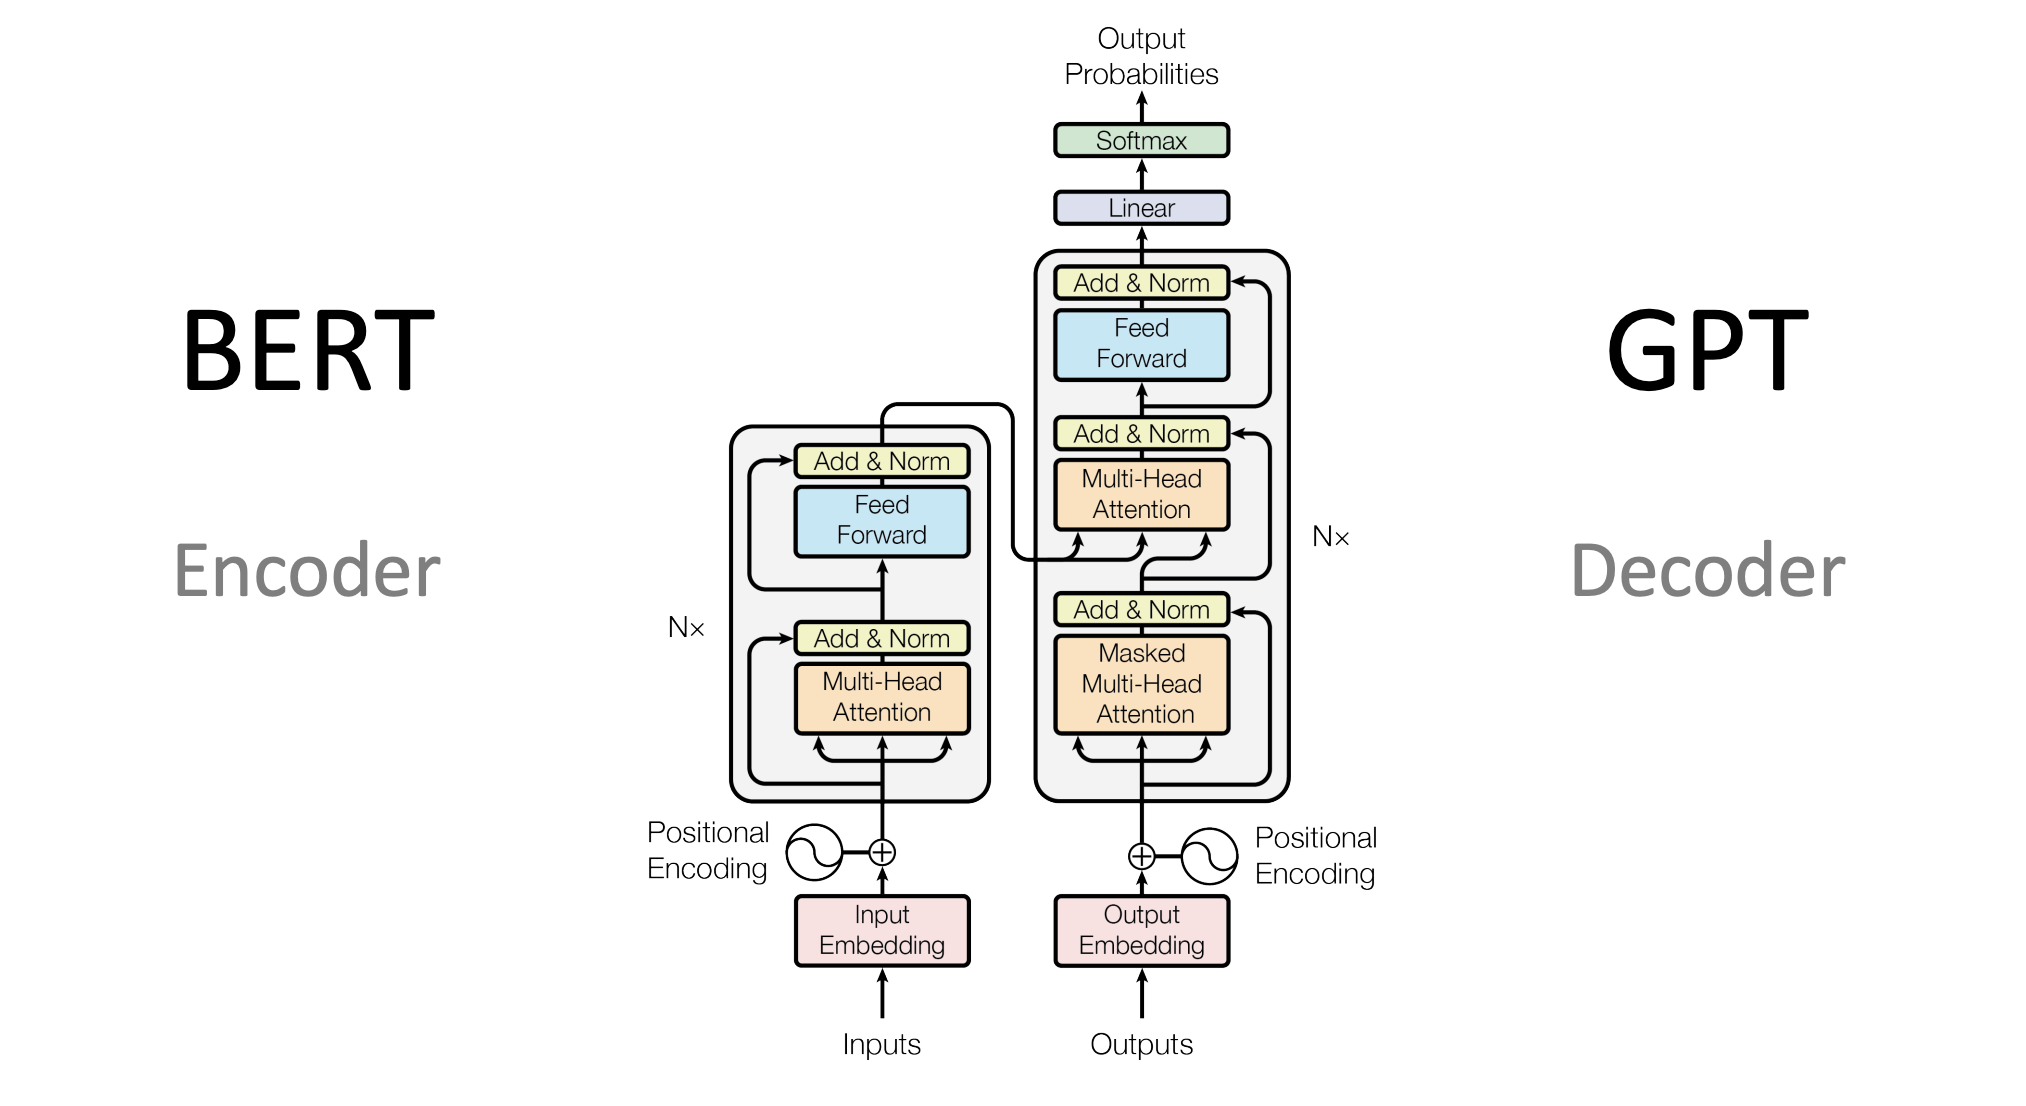

In [2]:
from PIL import Image
Image.open("./transformers.png")

In [14]:
# Add this - we know it's 128
vocab_size = 128
# Add this - let's do 100
intermediate_dim = 100

# Copy these from s4:
seq_len = 512
embed_dim = 256
num_attn_heads = 2
batch_size = 16

# Copied over from training loop, and CHANGE THE MODEL to MHSelfAttn

#model = nn.Sequential(
#    nn.Embedding(128, 16), # (vocab_size, embed_dim)
#    nn.Linear(16, 150),
#    nn.ReLU(),
#    nn.Linear(150,150),
#    nn.ReLU(),
#    nn.Linear(150, 128) # back to vocab_size
#)

model = nn.Sequential(

    nn.Embedding(vocab_size, embed_dim),

    # This is one decoder block
    MHSelfAttn(embed_dim, num_attn_heads),
    nn.LayerNorm(embed_dim),
    nn.Linear(embed_dim, intermediate_dim),
    nn.ReLU(),
    nn.Linear(intermediate_dim, embed_dim),

    # Copy the decoder block x times, here we just o one time
    MHSelfAttn(embed_dim, num_attn_heads),
    nn.LayerNorm(embed_dim),
    nn.Linear(embed_dim, intermediate_dim),
    nn.ReLU(),
    nn.Linear(intermediate_dim, embed_dim),

    # We add the projection layer (to the vocabulary):
    nn.Linear(embed_dim, vocab_size)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

segments = 10

# Add "train_": and "dataset" vs "data"
train_loader = iter(DataLoader(processed_train_dataset, batch_size=8, shuffle=True))

# Add the validation_loader
valid_loader = iter(DataLoader(processed_valid_dataset, batch_size=8, shuffle=True))

for idx in range(6):

    # Add "train_":
    batch = next(train_loader)  
    seqs, labels = batch[:,:-1], batch[:,1:]
    train_loss = 0

    # Need to move model.train() here since we're switching to eval() now in this loop
    model.train()

    for seqs_segment, labels_segment in zip(seqs.chunk(segments, dim=-1), labels.chunk(segments, dim=-1)): 

        optimizer.zero_grad()
        y_pred = model(seqs_segment) 
        y_pred = y_pred.transpose(2,1) 

        loss = loss_fn(y_pred, labels_segment) 
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    if idx % 2 == 0: 
        # Adding the string to make it clear that this is training loss.
        print("Training loss: ",(train_loss / segments)) 

# New in Stage 5: we are adding the validation loss

    if idx > 0 and idx % 2 == 0:

        batch = next(valid_loader)
        seqs, labels = batch[:,:-1], batch[:,1:]
        valid_loss = 0

        model.eval()

        # Copy from training section and adjusting for evaluation.
        for seqs_segment, labels_segment in zip(seqs.chunk(segments, dim=-1), labels.chunk(segments, dim=-1)): 
            with torch.no_grad(): # We are evaluating, so no need to compute gradients.
                #optimizer.zero_grad() -> Not needed for eval
                y_pred = model(seqs_segment) 
                y_pred = y_pred.transpose(2,1) 

                loss = loss_fn(y_pred, labels_segment) 
                #loss.backward() -> not needed for eval
                #optimizer.step() -> not needed for eval
                valid_loss += loss.item()

        print("Validation loss: ",  (valid_loss/segments))


Training loss:  4.07476840019226
Training loss:  3.299682283401489
Validation loss:  3.2751843214035032
Training loss:  3.2665398836135866
Validation loss:  3.2697110414505004
